In [2]:
pip install pytenet

  Obtaining dependency information for pytenet from https://files.pythonhosted.org/packages/2d/95/2b29ceefa42357d2347ca824b0f423b66c585970b06cea15d566d13733b6/pytenet-1.2.0-py3-none-any.whl.metadata

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pytenet as ptn

In [4]:
# seed random number generator for reproducibility
rng = np.random.default_rng(42)

In [5]:
# physical dimension (of each lattice site);
# this could be spin 1, 0, -1 for example, or 0, 1, 2 particles per lattice site
d = 3

# virtual bond dimensions (note the leading and trailing 1)
D = [1, 4, 15, 13, 7, 1]

# set all physical and virtual bond quantum numbers to zero
# (effectively disabling quantum numbers)
qd = np.zeros(d, dtype=int)
qD = [np.zeros(Di, dtype=int) for Di in D]

# now create the matrix product state
mps = ptn.MPS(qd, qD, fill='random', rng=rng)

In [6]:
type(mps.A)

list

In [7]:
type(mps.A[0])

numpy.ndarray

In [8]:
mps.A[0].shape

(3, 1, 4)

In [9]:
# show random entries of leftmost tensor as illustration
mps.A[0]

array([[[ 0.06220011+0.01347846j, -0.21228587+0.23009715j,
          0.15318521+0.09542994j,  0.19199197-0.17540234j]],

       [[-0.39825339+0.07527094j, -0.26580628-0.19573109j,
          0.02609531+0.17931292j, -0.06455275-0.01019108j]],

       [[-0.00342952-0.03773487j, -0.17412686-0.13899416j,
          0.17950636+0.24955021j,  0.15876611-0.0315432j ]]])

In [10]:
# the number of lattice sites is (by definition) the length of mps.A;
# by construction same as length of virtual bond dimension list - 1
L = mps.nsites
(L, len(mps.A), len(D)-1)

(5, 5, 5)

In [11]:
mps.bond_dims

[1, 4, 15, 13, 7, 1]

In [13]:

x = mps.as_vector()
# the length of x is equal to the physical Hilbert space dimension,
# i.e., d^L with L the number of lattice sites:
(x.shape, d**L)

((243,), 243)

In [14]:

# in general, the MPS is not normalized
np.linalg.norm(x)

0.008733585128016282

In [15]:
mps.orthonormalize(mode='left')

0.00873358512801628

In [16]:
# now the norm is 1, as expected
x = mps.as_vector()
np.linalg.norm(x)

0.9999999999999999

In [17]:
# Hamiltonian parameters
t  =  1.0
U  =  4.0
mu = -0.5
# construct MPO (allowed local occupancies are 0, 1, ..., d - 1)
BH = ptn.bose_hubbard_mpo(d, L, t, U, mu)

In [18]:
# the first and second dimensions are the physical dimensions,
# and the third and fourth dimension the left and right virtual bond dimensions
(BH.A[0].shape, BH.A[1].shape, BH.A[2].shape)

((3, 3, 1, 4), (3, 3, 4, 4), (3, 3, 4, 4))

In [19]:
BH.A[0]

array([[[[0.        +0.j, 1.        +0.j, 0.        +0.j,
          0.        +0.j]],

        [[0.        +0.j, 0.        +0.j, 1.        +0.j,
          0.        +0.j]],

        [[0.        +0.j, 0.        +0.j, 0.        +0.j,
          0.        +0.j]]],


       [[[1.        +0.j, 0.        +0.j, 0.        +0.j,
          0.        +0.j]],

        [[0.        +0.j, 1.        +0.j, 0.        +0.j,
          0.5       +0.j]],

        [[0.        +0.j, 0.        +0.j, 1.41421356+0.j,
          0.        +0.j]]],


       [[[0.        +0.j, 0.        +0.j, 0.        +0.j,
          0.        +0.j]],

        [[1.41421356+0.j, 0.        +0.j, 0.        +0.j,
          0.        +0.j]],

        [[0.        +0.j, 1.        +0.j, 0.        +0.j,
          5.        +0.j]]]])

In [20]:
BH_mat = BH.as_matrix()

In [21]:
BH_mat.shape

(243, 243)

In [26]:

ptn.operator_average(mps, BH)

(9.249829654930814+2.968060797920573e-17j)

In [27]:
# should agree with matrix-vector representation
np.vdot(x, np.dot(BH_mat, x))

(9.249829654930814-1.9879140146989366e-16j)

-------------

In [28]:
# Pauli matrices
sigma_x = np.array([[0.,  1.], [1.,  0.]])
sigma_y = np.array([[0., -1j], [1j,  0.]])
sigma_z = np.array([[1.,  0.], [0., -1.]])

# store operators in a dictionary
opmap = {
    0: np.identity(2),
    1: sigma_x,
    2: sigma_y,
    3: sigma_z }

# create the symbolic operator chain 0.7 * I I X X Z I I ...
opchain = ptn.OpChain([1, 1, 3], [0, 0, 0, 0], 0.7, 2)
# The second parameter contains quantum numbers to be interleaved with the operators,
# see the section below for an explanation.
# The last argument is the first site which the operator chain acts on other than identities.

-----------

In [ ]:
pip install tensorflow

In [ ]:
pip install tensornetwork

In [5]:
import numpy as np
from tensornetwork import Node, contract_between
from autograd import grad, elementwise_grad
import scipy.optimize as opt
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [7]:
def build_hamiltonian(N, J, h):
    H = np.zeros((2**N, 2**N), dtype=complex)
    for i in range(N-1):
        # Interaction terms J_i * (σ_i^x σ_{i+1}^x + σ_i^y σ_{i+1}^y + σ_i^z σ_{i+1}^z)
        xx = kronecker_product([I]*i + [sigma_x, sigma_x] + [I]*(N-i-2))
        yy = kronecker_product([I]*i + [sigma_y, sigma_y] + [I]*(N-i-2))
        zz = kronecker_product([I]*i + [sigma_z, sigma_z] + [I]*(N-i-2))
        H += J[i] * (xx + yy + zz)
    
    for i in range(N):
        # External field terms h_i * σ_i^z
        z = kronecker_product([I]*i + [sigma_z] + [I]*(N-i-1))
        H += h[i] * z
    return H

In [8]:

def mps_circuit(params, N):
    """
    Construct a hardware-efficient variational MPS circuit ansatz.
    
    Args:
        params (np.ndarray): Variational parameters for the circuit.
        N (int): Number of qubits (system size).
        
    Returns:
        Node: Tensor network representation of the variational MPS state.
    """
    # Define single-qubit rotation gates
    rx = lambda theta: np.array([[np.cos(theta/2), -1j*np.sin(theta/2)],
                                 [-1j*np.sin(theta/2), np.cos(theta/2)]])
    ry = lambda theta: np.array([[np.cos(theta/2), -np.sin(theta/2)],
                                 [np.sin(theta/2), np.cos(theta/2)]])
    rz = lambda theta: np.array([[np.exp(-1j*theta/2), 0],
                                 [0, np.exp(1j*theta/2)]])
    
    # Initialize the MPS tensor
    mps = [None] * N
    mps[0] = Node(np.reshape(rz(params[0]) @ ry(params[1]) @ rz(params[2]), [2, 1, 1]))
    
    # Construct the MPS circuit
    for i in range(1, N):
        mps[i] = Node(np.reshape(rz(params[3*i]) @ ry(params[3*i+1]) @ rz(params[3*i+2]), [1, 2, 2, 1]))
        mps[i-1] = contract_between(mps[i-1], mps[i], [1], [2])
        
    return mps[N-1]


In [9]:
def energy_expectation(params, H, N):
    # Compute the energy expectation value of the variational MPS state
    # with respect to the Hamiltonian 'H' using tensor network contractions
    psi = mps_circuit(params, N)
    energy = contract_between(Node(H), Node(psi.conj()), Node(psi))
    return energy.tensor


In [10]:
def optimize_vqe(N, J, h, initial_params):
    H = build_hamiltonian(N, J, h)
    energy_grad = elementwise_grad(energy_expectation)

    def objective_fn(params):
        energy = energy_expectation(params, H, N)
        return energy.real

    def gradient_fn(params):
        grad_vec = energy_grad(params, H, N)
        return grad_vec.real

    opt_result = opt.minimize(objective_fn, initial_params, jac=gradient_fn,
                              method='L-BFGS-B')
    opt_params = opt_result.x
    ground_state_energy = opt_result.fun
    return ground_state_energy, opt_params

In [12]:
def kronecker_product(matrices):
    """ Calculate the Kronecker product of a list of matrices """
    result = matrices[0]
    for matrix in matrices[1:]:
        result = np.kron(result, matrix)
    return result

In [90]:
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
I = np.eye(2)
# Example usage
N = 4  # System size
J = [1.0, 1.0, 1.0]  # Interaction strengths
h = [0.5, 0.5, 0.5, 0.5]  # External fields
initial_params = np.random.rand(10)  # Initial variational parameters

eigenvalues, eigenvectors = eigh(H)

# Ground state vector
ground_state_vector = eigenvectors[:, np.argmin(eigenvalues)]


In [18]:
print("Ground State Energy:", np.min(eigenvalues))
print("Ground State Vector:", ground_state_vector)


Ground State Energy: -3.734386093655219
Ground State Vector: [ 0.        +0.j  0.        +0.j  0.        +0.j -0.51226782+0.j
  0.        +0.j  0.79055324+0.j -0.33557005-0.j  0.        +0.j]


In [91]:
import numpy as np
from scipy.linalg import expm
from qiskit import QuantumCircuit, execute, Aer
from qiskit.opflow import PauliSumOp, X, Y, Z
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator

In [82]:


def kronecker_product(matrices):
    result = np.eye(1)
    for m in matrices:
        result = np.kron(result, m)
    return result

def define_hamiltonian(n_qubits, J, h):
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    I = np.eye(2)
    
    H = np.zeros((2**n_qubits, 2**n_qubits), dtype=complex)
    for i in range(n_qubits - 1):
        H += J * (kronecker_product([I]*i + [sigma_x, sigma_x] + [I]*(n_qubits-i-2))
                 + kronecker_product([I]*i + [sigma_y, sigma_y] + [I]*(n_qubits-i-2))
                 + kronecker_product([I]*i + [sigma_z, sigma_z] + [I]*(n_qubits-i-2)))
    
    for i in range(n_qubits):
        H += h[i] * kronecker_product([I]*i + [sigma_z] + [I]*(n_qubits-i-1))
    
    return H

def mps_ansatz(n_qubits, params):
    """
    Define the MPS ansatz circuit.
    
    Args:
        n_qubits (int): Number of qubits.
        params (list): List of variational parameters.
        
    Returns:
        QuantumCircuit: The MPS ansatz circuit.
    """
    qc = QuantumCircuit(n_qubits)
    
    # Apply single-qubit rotations
    for i in range(n_qubits):
        qc.ry(params[3*i], i)
        qc.rz(params[3*i+1], i)
        qc.ry(params[3*i+2], i)
    
    # Apply two-qubit entanglers
    for i in range(n_qubits - 1):
        qc.cx(i, i+1)
        qc.ryy(params[3*n_qubits + 2*i], i, i+1)
        qc.rz(params[3*n_qubits + 2*i + 1], i+1)
        qc.cx(i, i+1)
    
    return qc

def vqe_cost_fn(params, hamiltonian, n_qubits):
    """
    Define the VQE cost function.
    
    Args:
        params (list): List of variational parameters.
        hamiltonian (numpy.ndarray): The Hamiltonian operator.
        n_qubits (int): Number of qubits.
        
    Returns:
        float: The expectation value of the Hamiltonian.
    """
    qc = mps_ansatz(n_qubits, params)
    simulator = StatevectorSimulator()
    job = execute(qc, simulator, optimization_level=0)
    statevector = job.result().get_statevector().data  # Convert Statevector to numpy array
    expectation = np.real(np.vdot(statevector, hamiltonian @ statevector))
    return expectation


def vqe_optimization(n_qubits, J, h, initial_params):
    """
    Perform VQE optimization to find the ground state energy.
    
    Args:
        n_qubits (int): Number of qubits.
        J (float): Coupling strength.
        h (list): List of local fields.
        initial_params (list): Initial variational parameters.
        
    Returns:
        float: The ground state energy.
        list: The optimized variational parameters.
    """
    hamiltonian = define_hamiltonian(n_qubits, J, h)
    
    # Generate the correct number of initial parameters
    num_params = 3 * n_qubits + 2 * (n_qubits - 1)
    if len(initial_params) != num_params:
        initial_params = np.random.uniform(-np.pi, np.pi, num_params)
    
    from scipy.optimize import minimize
    result = minimize(vqe_cost_fn, initial_params, args=(hamiltonian, n_qubits))
    ground_state_energy = result.fun
    optimized_params = result.x
    return ground_state_energy, optimized_params

# Example usage
n_qubits = 4
J = 1.0
h = [0.5, 0.2, -0.3, 0.1]
initial_params = np.random.uniform(-np.pi, np.pi, 3 * n_qubits + 2 * (n_qubits - 1))

try:
    ground_state_energy, optimized_params = vqe_optimization(n_qubits, J, h, initial_params)
    print(f"Ground state energy: {ground_state_energy}")
    print(f"Optimized parameters: {optimized_params}")
except Exception as e:
    print(f"Error during VQE optimization: {e}")


Ground state energy: -6.163234449378754
Optimized parameters: [ 1.57079606 -1.57079562 -0.0324418  -1.72738862 -1.62013836  0.30279403
  1.5707977   1.57079841  0.21281325  1.56880635 -1.51845621  1.6088192
 -4.71238933  1.52126221  2.90000517 -3.14159331 -4.71239085 -3.1415983 ]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


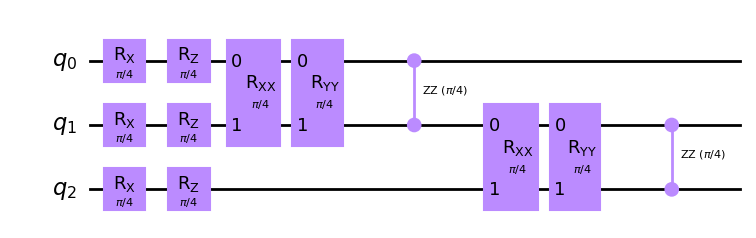

In [89]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate
import numpy as np

def hamiltonian_circuit(n_qubits, theta):
    qc = QuantumCircuit(n_qubits)
    
    # Apply transverse magnetic fields (X and Z fields)
    for i in range(n_qubits):
        qc.rx(theta, i)  # Simulate the effect of the Bx field
        qc.rz(theta, i)  # Simulate the effect of the Bz field

    # Apply interactions (XX, YY, ZZ)
    for i in range(n_qubits - 1):
        qc.append(RXXGate(theta), [i, i+1])  # XX coupling
        qc.append(RYYGate(theta), [i, i+1])  # YY coupling
        qc.append(RZZGate(theta), [i, i+1])  # ZZ coupling

    return qc

# Example usage
n_qubits = 3
theta = np.pi / 4  # Example angle for simulation
qc = hamiltonian_circuit(n_qubits, theta)
qc.draw(output='mpl')


Citation:<br>
[1]: https://github.com/cmendl/pytenet <br>
[2]: https://iopscience.iop.org/article/10.1088/2058-9565/acd9e7/pdf <br>
[3]: https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.5.023174